In [39]:
#Repositorio y librería a cargo del lector

In [3]:

NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

In [4]:
transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([.491, 0.482, 0.447],[0.247, 0.243, 0.261])
])

cifar10_train = datasets.CIFAR10(
    DATA_PATH,
    train = True,
    download=True,
    transform=transform_cifar
)

train_loader = DataLoader(
    cifar10_train,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))  #Elementos Aletorios
)

cifar10_val = datasets.CIFAR10(
    DATA_PATH, 
    train=False, 
    download=True, 
    transform=transform_cifar
)

val_loader = DataLoader(
    cifar10_val,
    batch_size=MINIBATCH_SIZE, 
    sampler=sampler.SubsetRandomSampler(range(NUM_VAL))
)

cifar10_test = datasets.CIFAR10(
    DATA_PATH, 
    train = False,
    download = True,
    transform = transform_cifar
)

test_loader = DataLoader(
    cifar10_test,
    batch_size = MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test)))
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/matasietephi/Documentos/jupyterNOTEBOOK/cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [7]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /home/matasietephi/Documentos/jupyterNOTEBOOK/cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


La muestra representa un:automobile


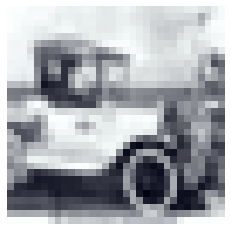

In [9]:
classes = test_loader.dataset.classes

def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()
    
rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La muestra representa un:{classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() - image.min())
plot_figure(image)

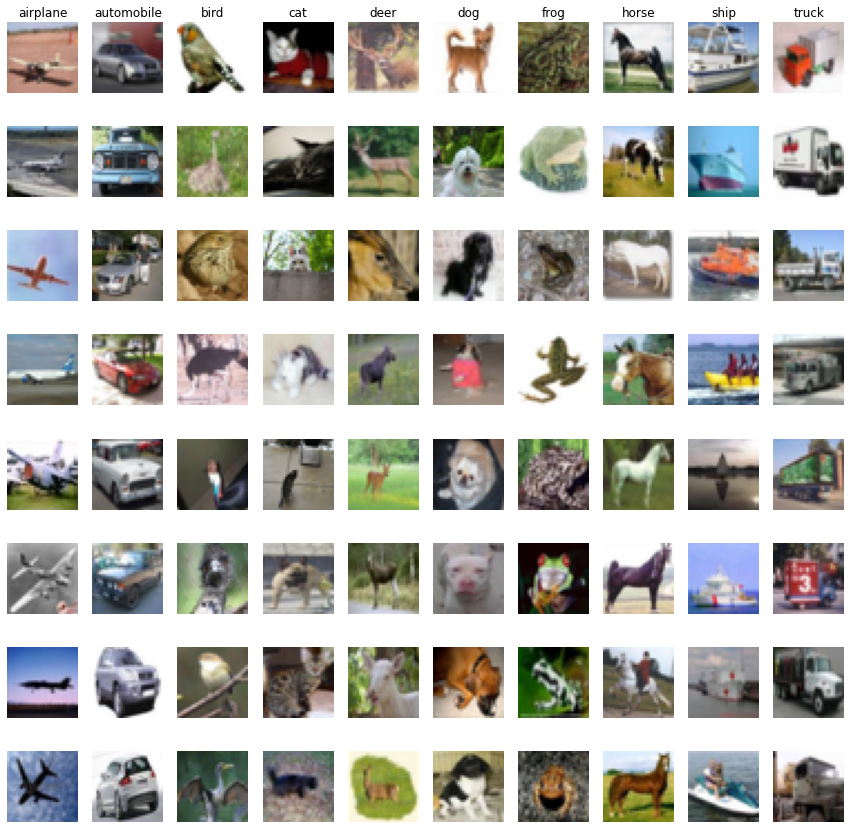

In [10]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace= False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()
    
plot_cifar10_grid()

In [11]:
for i, (x,y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 32, 32]) torch.Size([64])
1 torch.Size([64, 3, 32, 32]) torch.Size([64])
2 torch.Size([64, 3, 32, 32]) torch.Size([64])
3 torch.Size([64, 3, 32, 32]) torch.Size([64])
4 torch.Size([64, 3, 32, 32]) torch.Size([64])
5 torch.Size([64, 3, 32, 32]) torch.Size([64])
6 torch.Size([64, 3, 32, 32]) torch.Size([64])
7 torch.Size([64, 3, 32, 32]) torch.Size([64])
8 torch.Size([64, 3, 32, 32]) torch.Size([64])
9 torch.Size([64, 3, 32, 32]) torch.Size([64])
10 torch.Size([64, 3, 32, 32]) torch.Size([64])
11 torch.Size([64, 3, 32, 32]) torch.Size([64])
12 torch.Size([64, 3, 32, 32]) torch.Size([64])
13 torch.Size([64, 3, 32, 32]) torch.Size([64])
14 torch.Size([64, 3, 32, 32]) torch.Size([64])
15 torch.Size([64, 3, 32, 32]) torch.Size([64])
16 torch.Size([64, 3, 32, 32]) torch.Size([64])
17 torch.Size([64, 3, 32, 32]) torch.Size([64])
18 torch.Size([64, 3, 32, 32]) torch.Size([64])
19 torch.Size([64, 3, 32, 32]) torch.Size([64])
20 torch.Size([64, 3, 32, 32]) torch.Size([64])
21

In [12]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)           # Se obtiene los scores 
            _, pred = scores.max(dim=1) #se obtiene el máximo score, regresa el índice del max score
            num_correct += (pred == yi).sum() # Coloca 1 y 0 en las clases que corresponde, sumando, acumulando
            num_total += pred.size(0)         # Acumula el total de objetos correctos 
        return float(num_correct)/num_total   # Promedio de los resultados correctos 

In [13]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi,yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input=scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        print(f'Época:{epoch}, Costo:{cost.item()}, Accuracy:{acc},')
        

$\Huge{Modelo \ Lineal}$

In [17]:
hidden1 = 256
hidden = 256
lr = 0.0001
epochs = 10

model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(in_features=32*32*3, out_features=hidden1),
                       nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden),
                       nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10)
)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

train(model1, optimiser, epochs)

Época:0, Costo:1.924030065536499, Accuracy:0.4616,
Época:1, Costo:0.8789965510368347, Accuracy:0.5054,
Época:2, Costo:1.5251705646514893, Accuracy:0.5132,
Época:3, Costo:0.7330633401870728, Accuracy:0.526,
Época:4, Costo:1.100497841835022, Accuracy:0.5358,
Época:5, Costo:1.59039306640625, Accuracy:0.5414,
Época:6, Costo:0.6661211848258972, Accuracy:0.5422,
Época:7, Costo:1.0558404922485352, Accuracy:0.5446,
Época:8, Costo:1.4681082963943481, Accuracy:0.5398,
Época:9, Costo:1.0484744310379028, Accuracy:0.5484,


In [18]:
summary(model1)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            786,688
├─ReLU: 1-3                              --
├─Linear: 1-4                            65,792
├─ReLU: 1-5                              --
├─Linear: 1-6                            2,570
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0

$\huge{Modelo \ CNN}$

In [19]:
CHANNEL1 = 16
CHANNEL2 = 32
epochs = 10
lr = 0.0001

modelCNN1 =  nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels=CHANNEL1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=CHANNEL1, out_channels=CHANNEL2, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(in_features=16*16*CHANNEL2, out_features=10)
)
optimizer = torch.optim.Adam(modelCNN1.parameters(), lr)

In [20]:
train(modelCNN1, optimizer, epochs)

Época:0, Costo:1.4000191688537598, Accuracy:0.4786,
Época:1, Costo:1.3535395860671997, Accuracy:0.5142,
Época:2, Costo:0.9744030237197876, Accuracy:0.5396,
Época:3, Costo:1.0914922952651978, Accuracy:0.5528,
Época:4, Costo:1.163885235786438, Accuracy:0.5694,
Época:5, Costo:1.316638469696045, Accuracy:0.5776,
Época:6, Costo:1.4047608375549316, Accuracy:0.593,
Época:7, Costo:1.129680871963501, Accuracy:0.6108,
Época:8, Costo:1.66229248046875, Accuracy:0.6118,
Época:9, Costo:1.0498042106628418, Accuracy:0.6162,


In [21]:
summary(modelCNN1)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            448
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            4,640
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            81,930
Total params: 87,018
Trainable params: 87,018
Non-trainable params: 0

$\Huge{CNN  \ Orientada \ a \ Objetos \ (Clases)}$


In [22]:
class CNN_class1(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channel, 
                               out_channels = channel1, 
                               kernel_size = 3, 
                               padding = 1)
        self.conv2 = nn.Conv2d(in_channels = channel1, 
                               out_channels = channel2, 
                               kernel_size = 3, 
                               padding = 1)
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features = 16*16*channel2, out_features = 10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [23]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001

modelCNN2 = CNN_class1(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN2.parameters(), lr)

In [24]:
train(modelCNN2, optimiser,epochs)

Época:0, Costo:1.3865596055984497, Accuracy:0.4836,
Época:1, Costo:1.281598448753357, Accuracy:0.5286,
Época:2, Costo:1.3301647901535034, Accuracy:0.5542,
Época:3, Costo:1.1048299074172974, Accuracy:0.5816,
Época:4, Costo:0.8386484384536743, Accuracy:0.5926,
Época:5, Costo:0.7415614128112793, Accuracy:0.5942,
Época:6, Costo:1.0581282377243042, Accuracy:0.6208,
Época:7, Costo:0.6830936074256897, Accuracy:0.628,
Época:8, Costo:0.6617364883422852, Accuracy:0.6282,
Época:9, Costo:0.7149646282196045, Accuracy:0.6396,


In [25]:
summary(modelCNN2)

Layer (type:depth-idx)                   Param #
CNN_class1                               --
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            4,640
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            81,930
├─Flatten: 1-5                           --
Total params: 87,018
Trainable params: 87,018
Non-trainable params: 0

$\huge{Modelo \ CNN \ Optimo}$

In [26]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

class CNN_class2(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        nn.init.kaiming_uniform_(self.conv1.weight) #inicializador 
        self.conv2 = conv_k_3(channel1, channel2)
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features = 16*16*channel2, out_features = 10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [27]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001

modelCNN3 = CNN_class2(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN3.parameters(), lr)

In [28]:
train(modelCNN3, optimiser,epochs)

Época:0, Costo:1.5512903928756714, Accuracy:0.515,
Época:1, Costo:1.3064192533493042, Accuracy:0.5392,
Época:2, Costo:1.2547675371170044, Accuracy:0.569,
Época:3, Costo:1.208776831626892, Accuracy:0.5882,
Época:4, Costo:1.326955795288086, Accuracy:0.5998,
Época:5, Costo:0.9835937023162842, Accuracy:0.6166,
Época:6, Costo:1.157646656036377, Accuracy:0.6252,
Época:7, Costo:1.0659304857254028, Accuracy:0.633,
Época:8, Costo:0.8535409569740295, Accuracy:0.636,
Época:9, Costo:1.1282413005828857, Accuracy:0.6432,


In [29]:
summary(modelCNN3)

Layer (type:depth-idx)                   Param #
CNN_class2                               --
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            4,640
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            81,930
├─Flatten: 1-5                           --
Total params: 87,018
Trainable params: 87,018
Non-trainable params: 0

$\huge{CNN \ optimo \ capas \ BatchNormalization}$

In [30]:
class CNN_class3(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)
        
        self.conv2 = conv_k_3(channel1, channel2)
        
        self.bn2 = nn.BatchNorm2d(channel2)
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features = 16*16*channel2, out_features = 10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [31]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001

modelCNN4 = CNN_class3(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN4.parameters(), lr)

In [32]:
train(modelCNN4, optimiser,epochs)

Época:0, Costo:0.9889870285987854, Accuracy:0.5692,
Época:1, Costo:0.7274842262268066, Accuracy:0.6178,
Época:2, Costo:1.0707734823226929, Accuracy:0.6372,
Época:3, Costo:0.557931125164032, Accuracy:0.6548,
Época:4, Costo:0.9675845503807068, Accuracy:0.6596,
Época:5, Costo:0.8950891494750977, Accuracy:0.6642,
Época:6, Costo:0.7394437193870544, Accuracy:0.6712,
Época:7, Costo:0.7439027428627014, Accuracy:0.6664,
Época:8, Costo:0.7848008871078491, Accuracy:0.6654,
Época:9, Costo:0.854713499546051, Accuracy:0.6678,


In [33]:
summary(modelCNN4)

Layer (type:depth-idx)                   Param #
CNN_class3                               --
├─Conv2d: 1-1                            448
├─BatchNorm2d: 1-2                       32
├─Conv2d: 1-3                            4,640
├─BatchNorm2d: 1-4                       64
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            81,930
├─Flatten: 1-7                           --
Total params: 87,114
Trainable params: 87,114
Non-trainable params: 0

$\huge{CNN \ 4 \ Capas}$

In [34]:
class CNN_class4(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)
        
        self.conv2 = conv_k_3(channel1, channel2)
        
        self.bn2 = nn.BatchNorm2d(channel2)
        self.max_pool = nn.MaxPool2d(2,2)
        
       
    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        return self.max_pool(x)

In [35]:
channel1 = 16
channel2 = 32
channel3 = 64
channel4 = 128

epochs = 10
lr = 0.001

modelCNN5 = nn.Sequential(
    CNN_class4(3, channel1, channel2),
    CNN_class4(channel2,channel4, channel4),
    nn.Flatten(), 
    nn.Linear(in_features=8*8*channel4, out_features=10))

optimiser = torch.optim.Adam(modelCNN5.parameters(), lr)

In [36]:
train(modelCNN5, optimiser, epochs )

Época:0, Costo:1.3218616247177124, Accuracy:0.6324,
Época:1, Costo:1.0258184671401978, Accuracy:0.7058,
Época:2, Costo:0.4658661484718323, Accuracy:0.7478,
Época:3, Costo:0.39645877480506897, Accuracy:0.7652,
Época:4, Costo:0.12679259479045868, Accuracy:0.7708,
Época:5, Costo:0.4068717062473297, Accuracy:0.7852,
Época:6, Costo:0.27635958790779114, Accuracy:0.7726,
Época:7, Costo:0.12907938659191132, Accuracy:0.7774,
Época:8, Costo:0.17468830943107605, Accuracy:0.7858,
Época:9, Costo:0.3265719413757324, Accuracy:0.7846,


In [38]:
summary(modelCNN5)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─CNN_class4: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─BatchNorm2d: 2-2                  32
│    └─Conv2d: 2-3                       4,640
│    └─BatchNorm2d: 2-4                  64
│    └─MaxPool2d: 2-5                    --
├─CNN_class4: 1-2                        --
│    └─Conv2d: 2-6                       36,992
│    └─BatchNorm2d: 2-7                  256
│    └─Conv2d: 2-8                       147,584
│    └─BatchNorm2d: 2-9                  256
│    └─MaxPool2d: 2-10                   --
├─Flatten: 1-3                           --
├─Linear: 1-4                            81,930
Total params: 272,202
Trainable params: 272,202
Non-trainable params: 0